# Calculating error transfer matrices
In this example we would like to calculate the error transfer matrices of a two-qubit gateset for singlet-triplet qubits subject to $1/f$-like charge noise that are manipulated via a detuning-controlled exchange interaction. The error transfer matrix is here understood as the Liouville representation of the error propagator $\tilde{U}(\tau)$, or more precisely, as the first order correction to the identity process,

$$
\mathcal{\tilde{U}} = \mathbb{1} - \mathcal{\tilde{U}}^{(1)},
$$

where $\mathcal{\tilde{U}}_{ij} = \mathrm{tr}(C_i\tilde{U}C_j\tilde{U}^\dagger)$ and $\mathcal{\tilde{U}}^{(1)}$ is what we refer to as the 'error transfer matrix'. It captures the deviation from the identity up to second order in noise and can be used to extract many useful quantities that describe the (unitary, in this case) channel. For instance, the entanglement infidelity of the pulse is given by

$$
d^2\mathcal{I}_\mathrm{e} = \mathrm{tr}\mathcal{\tilde{U}}^{(1)}
$$

and the state fidelity (probability that a state is returned to itself) for pure input states by

$$
p_{j\rightarrow j} = \langle\!\langle\rho_j\rvert\mathcal{Q}\mathcal{\tilde{U}}\lvert\rho_j\rangle\!\rangle
$$

with $\lvert\rho_j\rangle\!\rangle = \sum_{k=0}^{d^2-1}\mathrm{tr}(C_k\rho_j)\lvert k\rangle\!\rangle$ the vectorized density matrix in the basis $\mathcal{C}$ and $\mathcal{Q}$ the Liouville representation of the total propagator $Q$.

Again we use the optimized gates presented in [Cerfontaine et al. (2019)] and start by loading the data and setting up the control operators $A_i$.

[Cerfontaine et al. (2019)]: https://arxiv.org/abs/1901.00851

In [1]:
import sys
from pathlib import Path

import numpy as np
from qutip.qip import operations
from qutip.visualization import matrix_histogram_complex
from scipy import io

import filter_functions as ff
from filter_functions import util

In [2]:
data_path = Path(sys.path[0]).parent.parent.parent / 'examples/data'

gates = ['X2ID', 'Y2ID', 'CNOT']
struct = {'X2ID': io.loadmat(str(data_path / 'X2ID.mat')),
          'Y2ID': io.loadmat(str(data_path / 'Y2ID.mat')),
          'CNOT': io.loadmat(str(data_path / 'CNOT.mat'))}
eps = {key: np.asarray(struct[key]['eps'], order='C') for key in gates}
dt = {key: np.asarray(struct[key]['t'].ravel(), order='C') for key in gates}
B = {key: np.asarray(struct[key]['B'].ravel(), order='C') for key in gates}
B_avg = {key: struct[key]['BAvg'].ravel() for key in gates}
infid_fast = {key: struct[key]['infid_fast'].ravel() for key in gates}
# B_avg same for all
B_avg = B_avg['X2ID']
T = {key: val.sum() for key, val in dt.items()}

J = {key: np.exp(eps[key]) for key in gates}
n_dt = {key: len(dt[key]) for key in gates}

d = 16
H = np.empty((6, d, d), dtype=complex)

Id, Px, Py, Pz = util.paulis
# Exchange Hamiltonians
H[0] = 1/4*sum(util.tensor(P, P, Id, Id) for P in (Px, Py, Pz))
H[1] = 1/4*sum(util.tensor(Id, P, P, Id) for P in (Px, Py, Pz))
H[2] = 1/4*sum(util.tensor(Id, Id, P, P) for P in (Px, Py, Pz))
# Zeeman Hamiltonians
H[3] = 1/8*(util.tensor(Pz, Id, Id, Id)*(-3) +
            util.tensor(Id, Pz, Id, Id) +
            util.tensor(Id, Id, Pz, Id) +
            util.tensor(Id, Id, Id, Pz))
H[4] = 1/4*(util.tensor(Pz, Id, Id, Id)*(-1) +
            util.tensor(Id, Pz, Id, Id)*(-1) +
            util.tensor(Id, Id, Pz, Id) +
            util.tensor(Id, Id, Id, Pz))
H[5] = 1/8*(util.tensor(Pz, Id, Id, Id)*(-1) +
            util.tensor(Id, Pz, Id, Id)*(-1) +
            util.tensor(Id, Id, Pz, Id)*(-1) +
            util.tensor(Id, Id, Id, Pz)*3)

# Technically there would also be H_0 (the mean magnetic field), but on the
# m_s = 0 subspace it is zero.

## Defining a custom basis
Because we are interested in the fidelity of the two-qubit gates that live on the $4\times 4$ subspace of the complete $16$-dimensional Hilbert space, we single out the $6\times 6$ subspace with magnetic spin quantum number $m_s = 0$ in which the qubits are encoded. We have to include the leakage levels $\bigl\lbrace\lvert\downarrow\downarrow\uparrow\uparrow\rangle, \lvert\uparrow\uparrow\downarrow\downarrow\rangle\bigr\rbrace$ as they are accessible via the intermediate exchange interaction $J(\epsilon_{23})$ during the gate sequence.

In [3]:
opers = list(H)

# Reduce to 6x6 subspace
zerospin_subspace_inds = ((3, 5, 6, 9, 10, 12), (3, 5, 6, 9, 10, 12))
d_zerospin_subspace = 6
opers = [H[np.ix_(*zerospin_subspace_inds)] for H in H]

# Subtract identity to make Hamiltonian traceless (always allowed since we are
# not interested in absolute energies)
opers = [oper - np.trace(oper)/d_zerospin_subspace*np.eye(d_zerospin_subspace)
         for oper in opers]

# The coefficients are the exchange couplings and B-field gradients
c_coeffs = {key: [J[key][0],
                  J[key][1],
                  J[key][2],
                  B[key][0]*np.ones(n_dt[key]),
                  B[key][1]*np.ones(n_dt[key]),
                  B[key][2]*np.ones(n_dt[key])] for key in gates}
# We include the exponential dependence of J on epsilon by a first-order
# derivative (just J back) as noise sensitivity.
n_coeffs = {key: [J[key][0],
                  J[key][1],
                  J[key][2],
                  np.ones(n_dt[key]),
                  np.ones(n_dt[key]),
                  np.ones(n_dt[key])] for key in gates}

identifiers = ['J_12', 'J_23', 'J_34', 'B_12', 'B_23', 'B_34']

H_c = {key: list(zip(opers, val, identifiers))
       for key, val in c_coeffs.items()}
H_n = {key: list(zip(opers, val, identifiers))
       for key, val in n_coeffs.items()}

In order to be able to distinguish the qubit subspace from the leakage subspace, we define a basis that exclusively has elements that only live on either by padding a two-qubit Pauli basis with zeros on the leakage subspace and letting the ``Basis`` constructor fill up the basis so that it is orthonormal and complete on the entire space.

In [4]:
# Leakage levels are at indices 0 and 5 of the 6x6 Hamiltonian
qubit_subspace_inds = ((1, 2, 3, 4), (1, 2, 3, 4))

basis = ff.Basis([np.pad(b, 1, 'constant') for b in ff.Basis.pauli(2)])

print('Basis orthonormal:', basis.isorthonorm)
print('Basis complete:', basis.iscomplete)
# Print one element as an example
print('Padded IX:\n', basis[1].real)

Basis orthonormal: True
Basis complete: True
Padded IX:
 [[0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.5 0.  0.  0. ]
 [0.  0.5 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.5 0. ]
 [0.  0.  0.  0.5 0.  0. ]
 [0.  0.  0.  0.  0.  0. ]]


Now we can initialize the `PulseSequence` instances and diagonalize them to verify they give rise to the correct gates:

In [5]:
# Initialize the PulseSequences
pulses = {
    gate: ff.PulseSequence(H_c[gate], H_n[gate], dt[gate], basis=basis)
    for gate in gates
}

# Target gates
U_t = {
    'X2ID': util.tensor((Id - 1j*Px)/np.sqrt(2), Id),    # sqrt X
    'Y2ID': util.tensor((Id - 1j*Py)/np.sqrt(2), Id),    # sqrt Y
    'CNOT': operations.cnot()
}

Correct action of the gates:
----------------------------
X2ID	True
Y2ID	True
CNOT	True


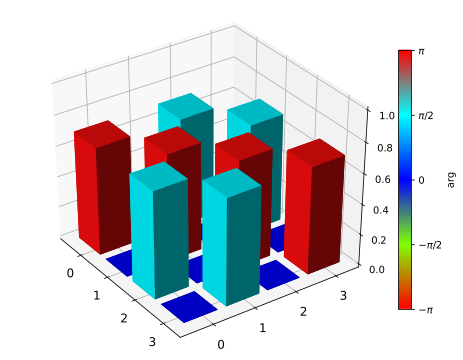

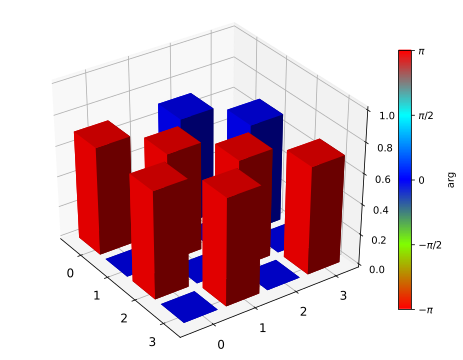

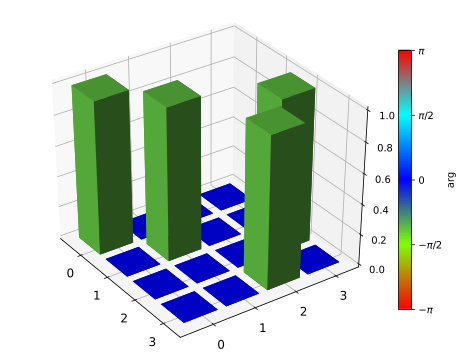

In [6]:
print('Correct action of the gates:')
print('----------------------------')
for key, pulse in pulses.items():
    pulse.diagonalize()
    # Reduce to qubit subspace
    U = pulse.total_Q[np.ix_(*qubit_subspace_inds)]
    # Plot the propagator
    matrix_histogram_complex(U)
    # Check for equality with the target unitary up to global phase
    print(key, util.oper_equiv(U_t[key], U, eps=1e-9)[0], sep='\t')

## Noise power spectral density
Now that we have verified that our pulses do what they are supposed to, we can turn to calculating the error transfer matrix given a noise spectrum. As a quick reminder, the noise power spectral density $S_\alpha(\omega)$ is defined as the Fourier transform of the autocorrelation function of the noise variable $b_\alpha(t)$. For *wide-sense stationary* noise the autocorrelation only depends on the time difference and we have

$$
    \langle b_\alpha(t_1)b_\alpha(t_2)\rangle = \int_{-\infty}^\infty\frac{\mathrm{d}\omega}{2\pi}S_\alpha(\omega)e^{i\omega(t_2 - t_1)}
$$

where $S_\alpha(\omega)$ is the two-sided power spectral density for noise source $\alpha$. We consider here $1/f$-like noise with a one-sided spectrum of

$$
    S_\epsilon(f) = A f^{-0.7}, \quad S_\epsilon(f=1\,\text{MHz}) = 4\times 10^{-20}\,\text{V}^2/\text{Hz}
$$

as reported by [Dial et al. (2013)].

[Dial et al. (2013)]: https://doi.org/10.1103/PhysRevLett.110.146804

In [7]:
# Voltages are in units of eps0 and energies in units of inverse nanoseconds
# (see Cerfontaine et al. (2019))
eps0 = 2.7241e-4
alpha = 0.7
# S(f) = A f^{-\alpha}
# At f = 1 MHz = 1e-3 GHz, S = S_0 = 4e-20 V^2/Hz = 4e-11/eps0^2 1/GHz
# Correspondingly, S(\omega) = A \omega^{-\alpha} such that at
# \omega = 2\pi 10^{-3} GHz, S_0 = 4e-11/eps0^2 1/GHz
S_0 = 4e-11/eps0**2
A = S_0*(2*np.pi*1e-3)**alpha

## Error transfer matrix
We now calculate the first order correction to the error transfer matrix, $\mathcal{\tilde{U}}^{(1)} = 1 - \mathrm{tr}(C_i\tilde{U}C_j\tilde{U}^\dagger)$ due to fast noise for each gate by numerically integrating over the spectrum times the filter function using $\omega_\text{IR}=1/T$ and $\omega_\text{UV}=100\,\text{GHz}$ as infrared and ultraviolet cutoffs, respectively, and compare to the Monte Carlo results presented by Cerfontaine et al. (2019).

### Performance considerations
For the computation of the error transfer matrix it is beneficial for the basis used to be sparse since the elements of the matrix are sums of terms proportional to traces of four basis elements of the form $\mathrm{tr}(C_i C_j C_k C_l)$. These traces are inherently mostly zero since the basis elements form an orthonormal set. If the elements themselves are sparse, the entire calculation can be performed quite efficiently. The Generalized Gell-Mann bases are sparse bases as most of their elements only have two non-zero entries. The Pauli bases have filling factor $1/2$ on the other hand and thus take longer to compute.

Since the traces are cached, this only applies for the first time the error transfer matrix is computed.

### Calculation using `filter_functions`
The calculation is implemented in the `ff.error_transfer_matrix()` function, which takes a `PulseSequence` instance, a noise spectrum and a list of frequencies as arguments. Optionally, we may also pass a list of identifiers corresponding to the noise operators whose contributions we are interested in. In our case we use the exchange terms affected by charge noise. The function will return an array with the separate noise operator contributions on the first axis.

Since the `filter_functions` package assumes two-sided spectra, we need to rescale the above spectrum by a factor of two accordingly. This can be done using `filter_functions.util.symmetrize_spectrum()`. Visualization of the error transfer matrices is implemented by ``filter_functions.plotting.plot_error_transfer_matrix()``.

In [8]:
from itertools import product
import matplotlib.pyplot as plt
from filter_functions import plotting
fig = plt.figure(figsize=(11, 15))

# First basis 16 elements are the Pauli basis on the qubit subspace
basis_labels = [''.join(tup) for tup in
                product(['I', 'X', 'Y', 'Z'], repeat=2)]
# Remaining basis elements were automatically generated and live only on 
# leakage subspace
basis_labels.extend([f'$C_{{{i}}}$' for i in range(16, 36)])

transfer_matrices = {}
for i, (key, pulse) in enumerate(pulses.items(), 1):
    omega_positive = np.geomspace(1/T[key], 1e2, 400)
    S_onesided = A/omega_positive**alpha
    S_twosided, omega = ff.util.symmetrize_spectrum(S_onesided, omega_positive)

    if key == 'CNOT':
        identifiers = ['J_12', 'J_23', 'J_34']
    else:
        # For single qubit pulses intermediate exchange is turned off
        identifiers = ['J_12', 'J_34']
        
    transfer_matrices[key] = ff.error_transfer_matrix(
        pulse, S_twosided, omega, n_oper_identifiers=identifiers,
        show_progressbar=True
    )
        
    # We can call plot_transfer matrix with the same arguments as
    # error_transfer_matrix in which case the transfer matrix is calculated on
    # the fly, or pass a pre-computed transfer matrix to the function
    fig, grid = plotting.plot_error_transfer_matrix(
        U=transfer_matrices[key], n_oper_identifiers=identifiers,
        basis_labels=basis_labels, grid_kw=dict(rect=10*31+i), figsize=(11, 4),
        fig=fig, cbar_label=key, colorscale='log'
    )

\\janeway\user ag bluhm\hangleiter\code\filter_functions\filter_functions\plotting.py:780: MatplotlibDeprecationWarning: default base may change from np.e to 10.  To suppress this warning specify the base keyword argument.
  norm = colors.SymLogNorm(linthresh=linthresh, vmin=Umin, vmax=Umax)


As we can see, for the single-qubit gates the computational and leakage subspaces are sufficiently decoupled and the structure of the error transfer matrix reveals a nice symmetry of noise processes on the two qubits. For the CNOT, this symmetry is not as pronounced and the error transfer matrix for the intermediate exchange $J_{23}$ mixes the computational and leakage subspaces to a small degree.

## Deriving quantities
With the error transfer matrix calculated, we can now derive different quantities. Here we take a look at the state fidelity of the computational basis states for the CNOT gate and the entanglement fidelities of the gates.

### State fidelity
The state fidelity is given by (see above)

$$
p_{j\rightarrow j} = \langle\!\langle\rho_j\rvert\mathcal{Q}\mathcal{\tilde{U}}\lvert\rho_j\rangle\!\rangle.
$$

We can calculate the vectorized density matrices $\lvert\rho_j\rangle\!\rangle$ using `ff.basis.expand()` and the Liouville representation of the total propagator of the pulse using `ff.liouville_representation()`.

p(00->00) = 9.9991e-01
p(01->01) = 9.9992e-01
p(10->10) = 2.3946e-05
p(11->11) = 2.3946e-05


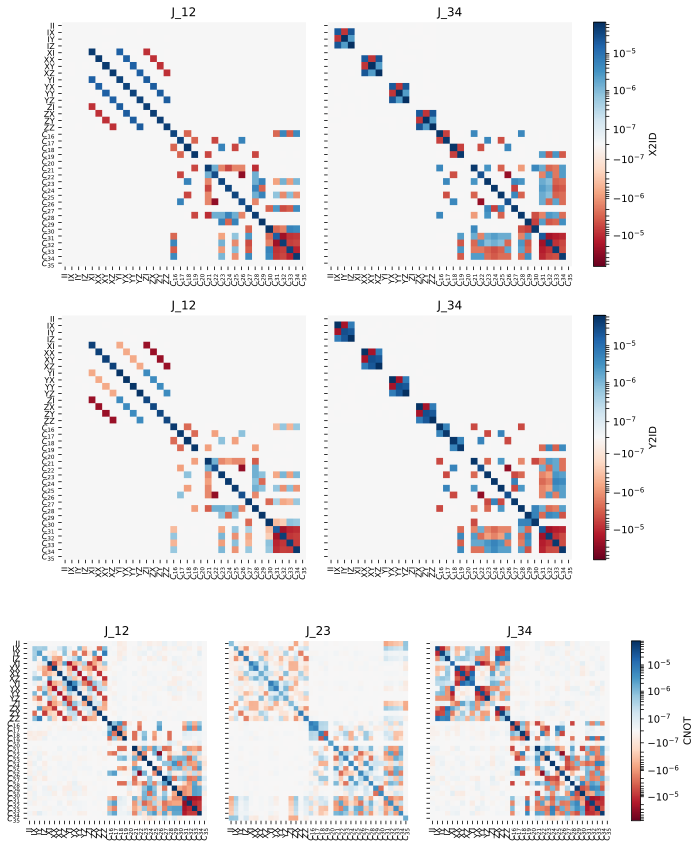

In [9]:
pulse = pulses['CNOT']
basis = pulse.basis
# Also exists as pulse.total_Q_liouville
total_Q_liouville = ff.liouville_representation(pulse.total_Q, basis)
# Sum up the individual noise operator contributions for simplicity
U_tilde = np.eye(36) - transfer_matrices['CNOT'].sum(axis=0)
ket_00, ket_01, ket_10, ket_11 = np.zeros((4, 6, 1))
ket_00[1] = 1
ket_01[2] = 1
ket_10[3] = 1
ket_11[4] = 1
rhoket_00 = ff.basis.expand(np.outer(ket_00, ket_00), basis).real
rhoket_01 = ff.basis.expand(np.outer(ket_01, ket_01), basis).real
rhoket_10 = ff.basis.expand(np.outer(ket_10, ket_10), basis).real
rhoket_11 = ff.basis.expand(np.outer(ket_11, ket_11), basis).real
rhokets = (rhoket_00, rhoket_01, rhoket_10, rhoket_11)
labels = ('00', '01', '10', '11')

for label, rhoket in zip(labels, rhokets):
    F = rhoket.T @ total_Q_liouville @ U_tilde @ rhoket
    print(f'p({label}->{label}) = {F.real:.4e}')

The probabilities are not exactly one and zero but differ from the target outcome by $\sim 10^{-5}$ due to the influence of the noise.

### Entanglement fidelity <a id='fidelity'></a>
The entanglement fidelity is given by (see above)

$$
d^2\mathcal{I}_\mathrm{e} = \mathrm{tr}\mathcal{\tilde{U}}^{(1)}.
$$

We are only interested in the dynamics on the qubit subspace and thus do not care about contributions from basis elements on the leakage subspace, so that we only trace over the first 16 elements of the error transfer matrix. We will compare the results to the Monte Carlo results for fast noise from the reference.

Because the fidelity is an often-employed figure of merit, its calculation is also implemented in a separate function, `ff.infidelity()`, that is much faster than deriving the fidelity from the error transfer matrix. Its interface is very similiar to that of `ff.error_transfer_matrix()` and is thus not discussed here. Only note that some subtleties apply if calculating the fidelity in the presence of leakage levels.

In [10]:
print('Gate', 'Transfer Matrix', 'Monte Carlo', 'Relative deviation', sep='\t')
print('----------------------------------------------------------')
for key, pulse in pulses.items():
    infidelity = np.einsum('...ii', transfer_matrices[key][:, :16, :16])/4**2
    rel_div = (infidelity.sum() - infid_fast[key][1])/infid_fast[key][1]
    print(key,
          f'{infidelity.sum().real:.2e}',
          f'{infid_fast[key][1]:.2e}',
          f'{rel_div.real:.1e}',
          sep='\t')

Gate	Transfer Matrix	Monte Carlo	Relative deviation
----------------------------------------------------------
X2ID	7.24e-05	7.17e-05	9.6e-03
Y2ID	7.09e-05	7.03e-05	8.4e-03
CNOT	7.97e-05	7.89e-05	9.5e-03


## Convergence of the frequency integral
Since we are integrating numerically, we should also perform a convergence test in order to see if the frequency resolution is large enough. This is also implemented in `ff.infidelity()`. In this case, the function arguments `S` and `omega` take on a different meaning; `S` should be a `Callable` function handle for computing the spectrum from a list of frequencies, and `omega` should be a dictionary with entries defining the boundary conditions for the convergence test, e.g. the minimum and maximum number of frequency points $n_\omega$ for the convergence test. For brevity, we only show the convergence for the CNOT.

(11, 6)


Text(0.5, 0.98, 'CNOT convergence')

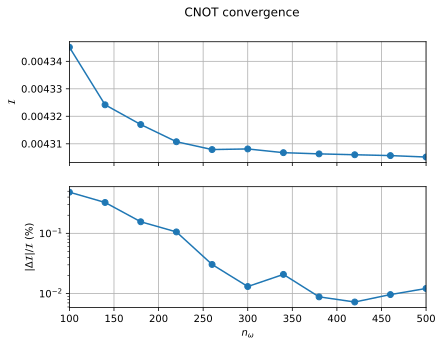

In [11]:
def S(omega): return A/omega**alpha

# Define the boundary conditions (all of these values also have sensible
# defaults)
omega = {
    'omega_IR': 1e-2/T['CNOT'],
    'omega_IV': 100,
    'spacing': 'log',
    'n_min': 100,
    'n_max': 500,
    'n_points': 10
}

n_omega, infids = ff.infidelity(pulses['CNOT'], S, omega, test_convergence=True)
print(infids.shape)
fig, ax = plotting.plot_infidelity_convergence(n_omega, infids.sum(axis=1))
fig.suptitle('CNOT convergence')

As we can see, the integral converges for around $n_\omega = 300$ already. Note that the value of the infidelity here is not consistent with the one computed in [the section above](#fidelity) since `ff.infidelity()` computes the infidelity of the pulse on the complete Hilbert space, not only the computational subspace. Concretely, `ff.infidelity()` computes `transfer_matrices['CNOT'].trace()/6**2`.